In [1]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

from helpers import helpplots_numu as plothelp
from helpers import helpfunction as helper
from helpers import plot_dicts_numu as plot_dicts

pd.set_option("display.max_columns", 500)

<IPython.core.display.Javascript object>

In [3]:
%autoreload

<IPython.core.display.Javascript object>

In [4]:
run = 1
input_dir = "./input/15Nov/run{}/".format(run)
output_dir = "./output/run{}/".format(run)

<IPython.core.display.Javascript object>

In [5]:
%%time
data = pickle.load(open(input_dir+"samples.pckl", 'rb'))
samples = list(data.keys())
title_str = "MicroBooNE Run{}: {:.1e} POT".format(run, data["on"]["pot"])

CPU times: user 619 ms, sys: 1.03 s, total: 1.64 s
Wall time: 1.64 s


<IPython.core.display.Javascript object>

In [6]:
q_muon_select = "trk_llr_pid_score_v>1.5 & trk_score_v>0.8 & trk_len_v>20 & pfp_generation_v==2 & trk_distance_v<4"
q_event_select = "muon_candidate & ~crtveto & _closestNuCosmicDist>20 & slpdg==14 & topological_score>0.06"

# q_muon_select = "trk_llr_pid_score_v>-10"
# q_event_select = "muon_candidate"

<IPython.core.display.Javascript object>

In [7]:
for k, v in data.items():
    muon_candidate = v["daughters"].eval(q_muon_select)
    muon_cand_maxll = (
        v["daughters"][muon_candidate]["trk_llr_pid_score_v"]
        .groupby("event")
        .transform(max)
        == v["daughters"][muon_candidate]["trk_llr_pid_score_v"]
    )
    v["daughters"]["muon_candidate"] = False
    v["daughters"].loc[
        muon_cand_maxll[muon_cand_maxll == True].index, "muon_candidate"
    ] = True
    # At some point you would like to broadcast this
    v["daughters"]["numuccinc"] = v["daughters"].eval(q_event_select)
    v["daughters"]["track_at_vtx"] = v["daughters"].eval(
        "trk_distance_v<3 & trk_distance_v>=0 & trk_score_v>0.3"
    )
    v["daughters"]["track_at_vtx"] = (
        v["daughters"]["track_at_vtx"].groupby("event").transform(sum)
    )

<IPython.core.display.Javascript object>

In [8]:
nu_df = pd.DataFrame(data["nu"]["mc"])

<IPython.core.display.Javascript object>

In [9]:
nu_df["true_vtx_fid"] = helper.is_fid(
    data["nu"]["mc"]["true_nu_vtx_x"],
    data["nu"]["mc"]["true_nu_vtx_y"],
    data["nu"]["mc"]["true_nu_vtx_z"],
)

<IPython.core.display.Javascript object>

In [10]:
q_30 = "abs(nu_pdg)==14 & nmuon==1 & nproton==0 & (npi0+npion)==0 & true_vtx_fid"
q_31 = "abs(nu_pdg)==14 & nmuon==1 & nproton>0 & (npi0+npion)==0 & true_vtx_fid"
q_32 = "abs(nu_pdg)==14 & nmuon==1 & (npi0+npion)>0 & true_vtx_fid"
q_33 = "abs(nu_pdg)==14 & nmuon==0 & true_vtx_fid"
q_10 = "abs(nu_pdg)==12 & true_vtx_fid"
q_5 = "true_vtx_fid==0"
new_cat = (
    nu_df.eval(q_30) * 30
    + nu_df.eval(q_31) * 31
    + nu_df.eval(q_32) * 32
    + nu_df.eval(q_33) * 33
    + nu_df.eval(q_10) * 10
    + nu_df.eval(q_5) * 5
)
nu_df["category"] = new_cat

<IPython.core.display.Javascript object>

In [11]:
q_30 = "category!=5 & abs(nu_pdg)==14 & nmuon==1 & nproton==0 & (npi0+npion)==0"
q_31 = "category!=5 & abs(nu_pdg)==14 & nmuon==1 & nproton>0 & (npi0+npion)==0"
q_32 = "category!=5 & abs(nu_pdg)==14 & nmuon==1 & (npi0+npion)>0"
q_33 = "category!=5 & abs(nu_pdg)==14 & nmuon==0"
q_10 = "category!=5 & abs(nu_pdg)==12"
q_5 = "category==5"
for k, v in data.items():
    if k not in helper.data_samples:
        new_cat = (
            v["daughters"].eval(q_30) * 30
            + v["daughters"].eval(q_31) * 31
            + v["daughters"].eval(q_32) * 32
            + v["daughters"].eval(q_33) * 33
            + v["daughters"].eval(q_10) * 10
            + v["daughters"].eval(q_5) * 5
        )
        v["daughters"]["category"] = new_cat
        cosmic = (v["daughters"]["nu_completeness_from_pfp"] < 0.2) & (
            v["daughters"]["category"] != 5
        )
        v["daughters"].loc[cosmic, "category"] = 4

<IPython.core.display.Javascript object>

In [12]:
print(data["nu"]["daughters"].query("numuccinc")["category"].value_counts())
print(nu_df["category"].value_counts())
print(sum(data["on"]["daughters"].eval("numuccinc")))

31    48047
5     40911
32    23507
30     9876
33     3012
4      2481
10       91
Name: category, dtype: int64
5     345156
31     85176
33     58334
32     43803
30     18351
10      1319
0          3
Name: category, dtype: int64
14337


<IPython.core.display.Javascript object>

In [13]:
sum(data["nu"]["daughters"].eval("numuccinc & category>29 & category<33")) / sum(
    nu_df.eval("category>29 & category<33")
)

0.5527048123260707

<IPython.core.display.Javascript object>

19266.978875756264
10189.735484719276
86721.4129499197
48543.33531713486
43776.63062018156
23493.113354444504


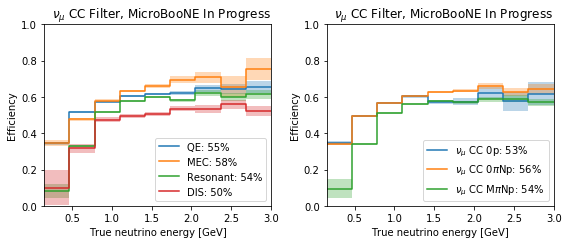

<IPython.core.display.Javascript object>

In [14]:
# eff per mode
cats = [0, 1, 2, 10]
field = "nu_e"
x_min = 0.15
x_max = 3
n_bins = 10
fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))


cats = [0, 10, 1, 2]
for cat in cats:
    num = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("interaction==@cat")[field]
    )
    den = nu_df.query("category>29 & category<33").query("interaction==@cat")[field]

    num_w = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("interaction==@cat")["weightSpline"]
    )
    den_w = nu_df.query("category>29 & category<33").query("interaction==@cat")[
        "weightSpline"
    ]

    eff, unc_low, unc_up, edges = plothelp.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[0].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[0].step(
        edges,
        eff,
        where="post",
        label="{0}: {1:.0f}%".format(
            plot_dicts.int_labels[cat], sum(num_w) / sum(den_w) * 100
        ),
    )
ax[0].set_title(r"$\nu_\mu$ CC Filter, MicroBooNE In Progress", loc="right")
ax[0].set_xlabel("True neutrino energy [GeV]")
ax[0].set_ylabel("Efficiency")
ax[0].set_ylim(0, 1)
ax[0].set_xlim(x_min, x_max)
ax[0].legend(loc="lower right")


cats = [30, 31, 32]
for cat in cats:
    num = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("category==@cat")[field]
    )
    den = nu_df.query("category>29 & category<33").query("category==@cat")[field]

    num_w = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("category==@cat")["weightSpline"]
    )
    den_w = nu_df.query("category>29 & category<33").query("category==@cat")[
        "weightSpline"
    ]
    print(sum(den_w))
    print(sum(num_w))
    eff, unc_low, unc_up, edges = plothelp.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[1].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[1].step(
        edges,
        eff,
        where="post",
        label="{0}: {1:.0f}%".format(
            plot_dicts.category_labels[cat], sum(num_w) / sum(den_w) * 100
        ),
    )
ax[1].set_title(r"$\nu_\mu$ CC Filter, MicroBooNE In Progress", loc="right")
ax[1].set_xlabel("True neutrino energy [GeV]")
ax[1].set_ylabel("Efficiency")
ax[1].set_ylim(0, 1)
ax[1].set_xlim(x_min, x_max)
ax[1].legend(loc="lower right")

fig.tight_layout()
fig.savefig(output_dir + "numu_efficiency.pdf", bbox_inches="tight")

In [15]:
# left
for k, v in dict_modes.items():
    if v == "?":
        continue
    type_sig = (d["nu"]["events"].array("mc_nu_interaction_type") == k) & sig_mask_ccinc
    type_sel = (d["nu"]["events"].array("mc_nu_interaction_type") == k) & sig_mask_sel

    denom = d["nu"]["events"].array("mc_nu_energy")[type_sig]
    nom = d["nu"]["events"].array("mc_nu_energy")[type_sel]

    data = [denom, nom]
    edges, _, bins, _, _ = helper.histHelper(10, kin_min_mu, 3, data)
    fraq = bins[1] / bins[0]
    err = np.sqrt(fraq * (1 - fraq) / bins[0])
    fraq = np.append(fraq, fraq[-1])
    err = np.append(err, err[-1])

    ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step="post")
    ax[0].step(
        edges,
        fraq,
        where="post",
        label="{0:>4}: Efficiency {1:0.1f}%".format(v, len(nom) / len(denom) * 100),
    )

ax[0].set_xlabel("True neutrino energy [GeV]")
ax[0].set_ylabel("Efficiency")
ax[0].set_ylim(0, 1)
ax[0].set_xlim(kin_min_mu, 3)
ax[0].legend(loc="upper left")


# right
for x_proton in range(4):
    denom = d["nu"]["events"].array("mc_nu_energy")[sig_masks_proton[x_proton]]
    nom = d["nu"]["events"].array("mc_nu_energy")[
        sig_masks_proton[x_proton] & d["nu"]["events"].array("nu_mu_cc_selected")
    ]

    data = [denom, nom]
    edges, _, bins, _, _ = helper.histHelper(10, kin_min_mu, 3, data)
    fraq = bins[1] / bins[0]
    err = np.sqrt(fraq * (1 - fraq) / bins[0])
    fraq = np.append(fraq, fraq[-1])
    err = np.append(err, err[-1])

    ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step="post")
    ax[1].step(
        edges,
        fraq,
        where="post",
        label="{0:>5}: Efficiency {1:0.1f}%".format(
            r"$1\mu$" + str(x_proton) + r"$p$", len(nom) / len(denom) * 100
        ),
    )
ax[1].set_xlabel("True neutrino energy [GeV]")
ax[1].set_ylabel("Efficiency")
ax[1].set_ylim(0, 1)
ax[0].set_xlim(kin_min_mu, 3)
ax[1].legend(loc=0)

ax[0].set_title(title_mc_str, loc="right")
ax[1].set_title(title_mc_str, loc="right")

fig.tight_layout()
fig.savefig(outdir + "modes_eff.pdf", bbox_inches="tight")

NameError: name 'dict_modes' is not defined

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "track_at_vtx",
    "Track multiplicity",
    N_bins=6,
    x_min=0.5,
    x_max=6.5,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.1,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.9,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/numu_vtxntrack.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(3 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "trk_mcs_muon_mom_v",
    "Muon Momentum (MCS) [GeV/c]",
    N_bins=30,
    x_min=0.146,
    x_max=1.25,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.1,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.7,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(output_dir + "data_mc/numu_mcsmom.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(3 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "trk_phi_v",
    r"Muon candidate $\phi$",
    N_bins=30,
    x_min=-np.pi,
    x_max=np.pi,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.25,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.0,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

x_ticks = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
x_labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_labels)


fig.tight_layout()
fig.savefig(output_dir + "data_mc/numu_phi.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(3 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "trk_theta_v",
    r"Muon candidate $\theta$",
    N_bins=30,
    x_min=0,
    x_max=np.pi,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.25,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.8,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

x_ticks = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]
x_labels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_labels)


fig.tight_layout()
fig.savefig(output_dir + "data_mc/numu_phi.pdf", bbox_inches="tight")

# Done